# Image Datasets

> Image datasets

In [ ]:
#| default_exp image.datasets

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export

# torch
import torch
from torch import Tensor # type hint
import torch.utils.data as data
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
# torchvision
from torchvision.transforms import transforms, Compose
# lightning
from lightning import LightningDataModule
# hugging face
from datasets import load_dataset, load_dataset_builder, ClassLabel
import datasets
# math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# python libs
import os
import logging
import warnings
from pprint import pprint
from plum import dispatch
# conigs
from omegaconf import OmegaConf
from hydra.utils import instantiate
# typing
from typing import Optional, Tuple, List, Callable, Union, Dict
# nimrod
from nimrod.data.core import DataModule
from nimrod.utils import set_seed

In [ ]:
#| export
set_seed(42)
logger = logging.getLogger(__name__)
# logger.setLevel(logging.DEBUG)
plt.set_loglevel('INFO')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

Seed set to 42


## ImageDataset Mixin

In [ ]:
#| export
class ImagePlotMixin:
    " Mixin class for image datasets providing visualization of (image, label) samples"

    @staticmethod
    def plot(
        ds: Dataset,
        idx: int,
        int2label: Dict[int, str] | Callable = None,

        ):
        X, label = ds[idx]
        C, H, W = X.shape
        if C == 1:
            # X (1, H, W)
            plt.imshow(X[0].numpy(), cmap='gray') 
        elif C == 3:
            # X (3, H, W)
            plt.imshow(X.numpy().transpose(1,2,0).reshape(H,W,C))
        # Convert label to string if possible
        try:
            # label_str = ds.hf_ds.features['label'].int2str(label)
            if isinstance(int2label, dict):
                label_str = int2label[label]
            elif isinstance(int2label, Callable):
                label_str = int2label(label)
            else:
                label_str = str(label)
        except AttributeError:  
            logger.warning("Unable to convert label to string")
        plt.title(f"Label: {label_str}")
        plt.show()

    @staticmethod
    def plot_grid(
        ds: Dataset,
        n_rows:int=3,
        n_cols:int=3,
        int2label: Dict[int, str] | Callable = None
        ):
        """
        Plot a grid of random images from the dataset
        
        Args:
            n_rows (int): Number of rows in the grid
            n_cols (int): Number of columns in the grid
        """
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
        
        # Flatten axs if it's a 2D array
        if n_rows > 1 and n_cols > 1:
            axs = axs.flatten()
        
        for i in range(n_rows * n_cols):
            # Randomly select an index
            idx = torch.randint(0, len(ds), (1,)).item()
            
            # Get image and label
            img, label = ds[idx]
            C, H, W = img.shape
            
            # Handle different channel configurations
            if C == 1:  # Grayscale
                plot_img = img[0].numpy()
                cmap = 'gray'
            elif C == 3:  # RGB
                plot_img = img.numpy().transpose(1, 2, 0).reshape(H,W,C)
                cmap = None
            
            # Plot the image
            axs[i].imshow(plot_img, cmap=cmap) #.astype(np.uint8)
            
            # Convert label to string if possible
            try:
                # label_str = ds.hf_ds.features['label'].int2str(label)
                if isinstance(int2label, dict):
                    label_str = int2label[label]
                elif isinstance(int2label, Callable):
                    label_str = int2label(label)
                else:
                    label_str = str(label)
            except AttributeError:
                logger.warning("Unable to convert label to string")
            
            axs[i].set_title(f"Label: {label_str}")
            axs[i].axis('off')
    
        plt.tight_layout()
        plt.show()

        

In [ ]:
# ImagePlotMixin.plot(test, 0)
# ImagePlotMixin.plot_grid(test, 2,2)
# ImagePlotMixin.plot(test, 0, int2label = {0:'zero', 1:'one', 2:'two', 3:'three', 4:'four', 5:'five', 6:'six', 7:'seven', 8:'eight', 9:'nine'})
# ImagePlotMixin.plot(test, 0, int2label = test.hf_ds.features['label'].int2str)
# ImagePlotMixin.plot_grid(test, 2,2, int2label = test.hf_ds.features['label'].int2str)

## Image Dataset

In [ ]:
#| export 

class ImageDataset(ImagePlotMixin, Dataset):
    "Image dataset"

    def __init__(
        self,
        name:str = "mnist",
        *args,
        data_dir:Optional[str]='../data/image', # path where data is saved if None default to hugging face cache
        split = 'train', # train or test dataset
        transforms:Optional[transforms.Compose]=transforms.Compose([
                transforms.ToTensor()]), #,transforms.Normalize((0.1307,), (0.3081,))]),
        streaming:bool = False, # TODO: support and test streaming datasest
        exclude_grey_scale = False,
        verification_mode="no_checks"
        
    ):

        if data_dir is not None:
            os.makedirs(data_dir, exist_ok=True)
        super().__init__()
        self.exclude_grey_scale = exclude_grey_scale
        self.info = load_dataset_builder(name, *args)
        if split not in self.info.info.splits:
            raise ValueError(f"The specified split '{split}' does not exist in the dataset '{name}'. Available splits: {list(info.info.splits.keys())}")

        self.hf_ds = load_dataset(
            name,
            *args,
            split=split,
            cache_dir=data_dir,
            download_mode='reuse_dataset_if_exists',
            streaming=streaming,
            verification_mode=verification_mode
            
        )
        self.image_column_name = 'image'
        if name == 'cifar10':
            self.image_column_name = 'img'
                
        self.images = self.hf_ds[self.image_column_name]

        if name == "huggan/smithsonian_butterflies_subset":
            # no default label col available using 'taxonomy' instead
            unique_labels =list(set(self.hf_ds['taxonomy']))
            cl = ClassLabel(names=unique_labels)
            self.hf_ds = self.hf_ds.map(lambda example: {'label': cl.str2int(example['taxonomy'])})
            self.hf_ds = self.hf_ds.cast_column('label', cl)

        self.labels = self.hf_ds['label']

        self.transform = transforms

    def add_label_column(example):
        example['label'] = cl.str2int(example['taxonomy'])
        return example

    @property
    def num_classes(self):
        return self.hf_ds.features['label'].num_classes
    
    @property
    def label_names(self)->List[str]:
        return self.hf_ds.features['label'].names
    
    @property
    def int2str(self):
        return self.hf_ds.features['label'].int2str
    
    @property
    def splits(self)->List[int]:
        return self.info.info.splits.keys()

    def __len__(self) -> int: # length of dataset
        return len(self.images)
    
    def __getitem__(
        self,
        idx:int # index into the dataset
    ) -> tuple[torch.FloatTensor, int]: # Y image data, x digit number
      
        image = np.array(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
            if self.exclude_grey_scale and image.size(0) != 3:
                logger.warning(f"Skipping sample at index {idx} because doesn't have 3 channels")
                next_idx = (idx + 1) % len(self)
                return self.__getitem__(next_idx)
        
        return image, label


    
    def train_dev_split(
        self,
        ratio:float, # percentage of train/dev split,
    ) -> tuple[Dataset, Dataset]: # train and set mnnist datasets

        train_set_size = int(len(self.images) * ratio)
        valid_set_size = len(self.images) - train_set_size
        ds = list(zip(self.images, self.labels))
        # split the train set into two randomly sample
        train_set, valid_set = data.random_split(ds, [train_set_size, valid_set_size])
        return train_set, valid_set

    def show(
        self,
        idx:int # index into the dataset
        ):
        self.plot(self, idx, self.hf_ds.features['label'].int2str)

    def show_grid(
        self,
        n_rows:int=3, # Number of rows in the grid
        n_cols:int=3 # Number of columns in the grid
        ):
        self.plot_grid(self, n_rows, n_cols, self.hf_ds.features['label'].int2str)
    

### Usage
Setup MNIST dataset. Download data if not found in specified location.

In [ ]:
test = ImageDataset(
    "huggan/smithsonian_butterflies_subset",
    data_dir=None,
    split='train',
    transforms=transforms.Compose([transforms.ToTensor(),transforms.Resize((160, 160))]), #,transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    exclude_grey_scale=True
)


Repo card metadata block was not found. Setting CardData to empty.
[17:07:42] WARNING - Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
[17:07:43] WARNING - Repo card metadata block was not found. Setting CardData to empty.


Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

[17:42:37] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02822975..1.0000002].


num_classes: 45, splits: dict_keys(['train']), labels: ['Animalia, Arthropoda, Insecta, Lepidoptera, Pyralidae, Epipaschiinae', 'Animalia, Arthropoda, Insecta, Lepidoptera, Geometridae, Larentiinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae, Nymphalinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae, Satyrinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Saturniidae, Saturniinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae, Limenitidinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Papilionidae, Papilioninae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Pieridae, Dismorphiinae', 'Animalia, Arthropoda, Insecta, Lepidoptera, Arctiidae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Lycaenidae', 'Animalia, Arthropoda, Insecta, Lepidoptera, Papilionidae, Parnassiinae', 'Animalia, Arthropoda, Insecta, Lepidoptera, Pyralidae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidopte

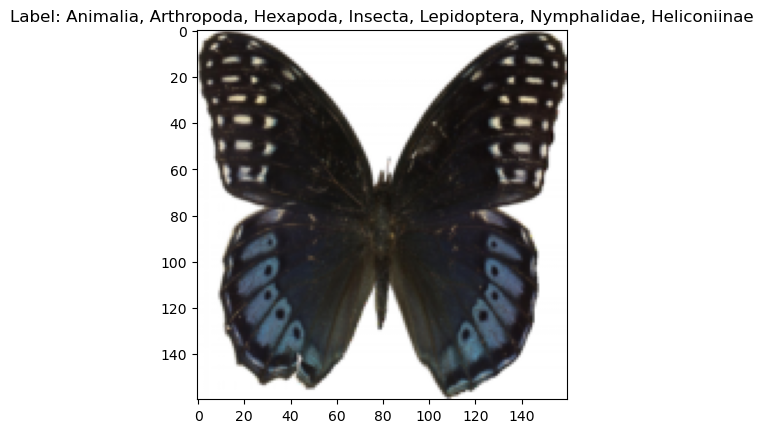

[17:42:37] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.021431256..1.0000002].
[17:42:37] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.084307164..1.0000002].
[17:42:37] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
[17:42:37] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
[17:42:37] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.022093028..1.0000002].
[17:42:37] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.020514851..1.0000002].
[17:42:37] WAR

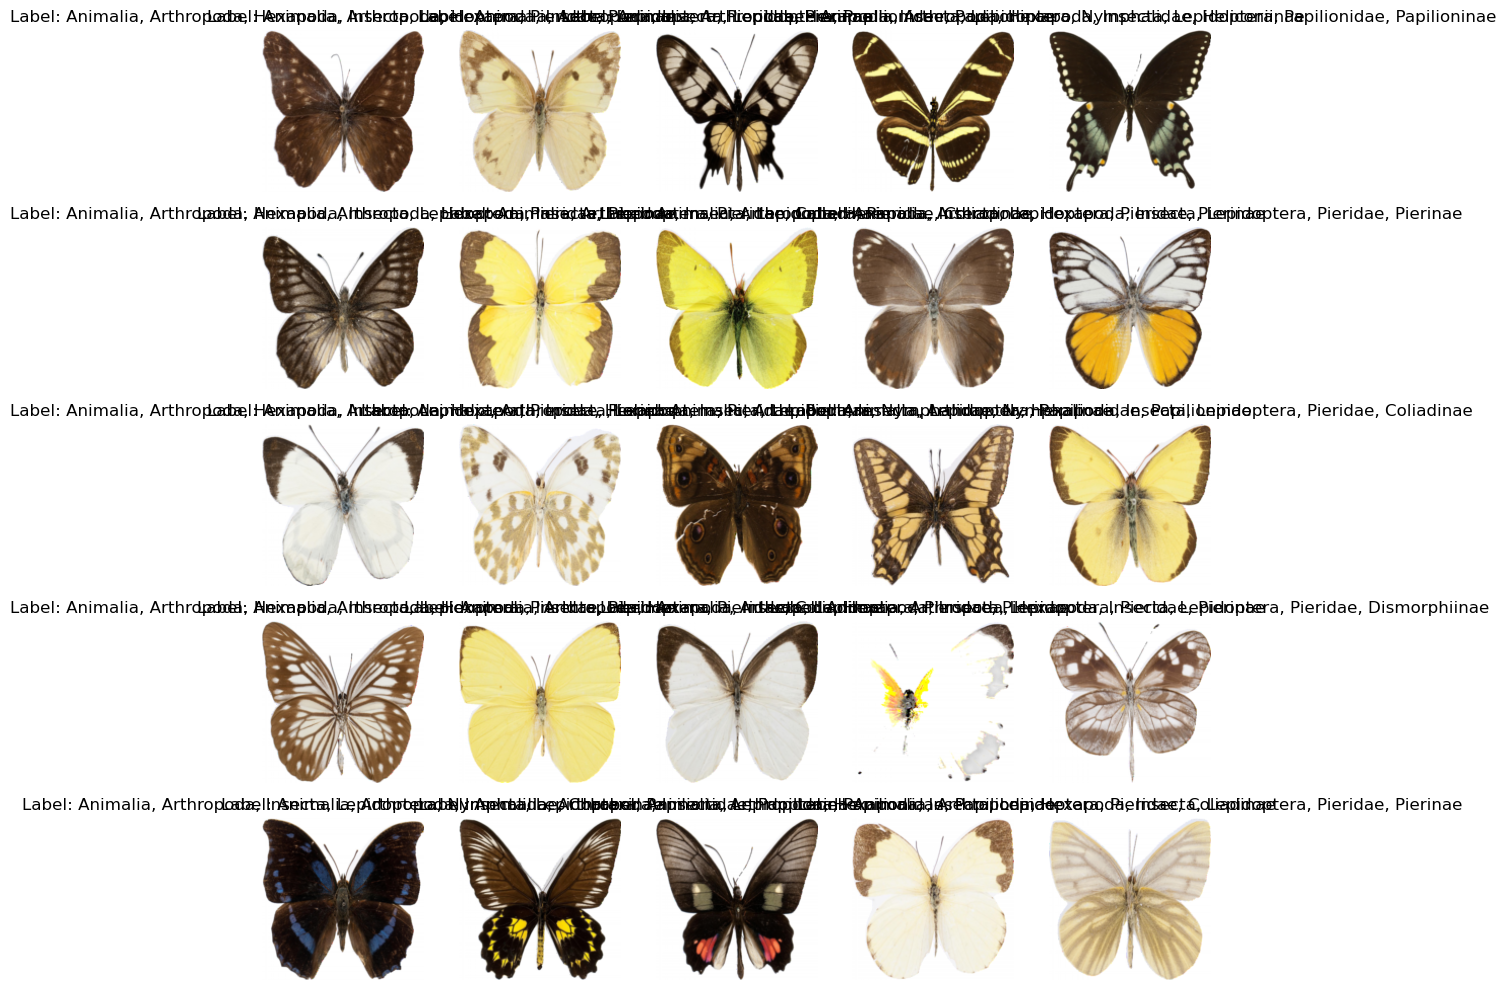

In [ ]:
print(f"num_classes: {test.num_classes}, splits: {test.splits}, labels: {test.label_names}")
print("from in to class method",test.hf_ds.features['label'].int2str)
print(test.hf_ds.features['label'])

idx = 10
print(f"label for image {idx} :", test[idx][1], test.int2str(test[idx][1]))
test.show(idx)
test.show_grid(5,5)

num_classes: 10, splits: dict_keys(['train', 'validation']), labels: ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
from in to class method <bound method ClassLabel.int2str of ClassLabel(names=['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute'], id=None)>
label for image 10 : 2 cassette player


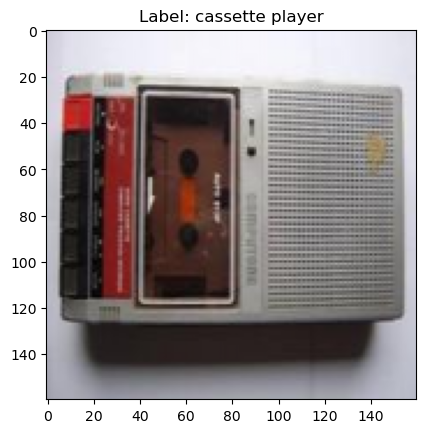

In [ ]:
#| notest

test = ImageDataset(
    'frgfm/imagenette',
    '160px',
    data_dir=None,
    split='validation',
    transforms=transforms.Compose([transforms.ToTensor(),transforms.Resize((160, 160))]), #,transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    exclude_grey_scale=True
)
print(f"num_classes: {test.num_classes}, splits: {test.splits}, labels: {test.label_names}")
print("from in to class method",test.hf_ds.features['label'].int2str)
# print(test.hf_ds.features['label'])
# test2 = ImageDataset('mnist', data_dir=None, train=True, transforms=transforms.ToTensor())
# test3 = ImageDataset('fashion_mnist', data_dir=None, train=True, transforms=transforms.ToTensor())
idx = 10
print(f"label for image {idx} :", test[idx][1], test.int2str(test[idx][1]))
test.show(idx)
test.show_grid(5,5)

In [ ]:
print(f" X: {test[0][0].shape}, y: {test[0][1]}")
dl = DataLoader(test, batch_size=64)
print(next(iter(dl))[0].shape, next(iter(dl))[1].shape)


 X: torch.Size([3, 160, 160]), y: 39
torch.Size([64, 3, 160, 160]) torch.Size([64])


[17:42:53] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018742988..1.0000002].


torch.float32 <class 'int'>
Number of samples in the dataset: 1000
torch.Size([3, 160, 160]) 39 torch.FloatTensor <class 'int'>


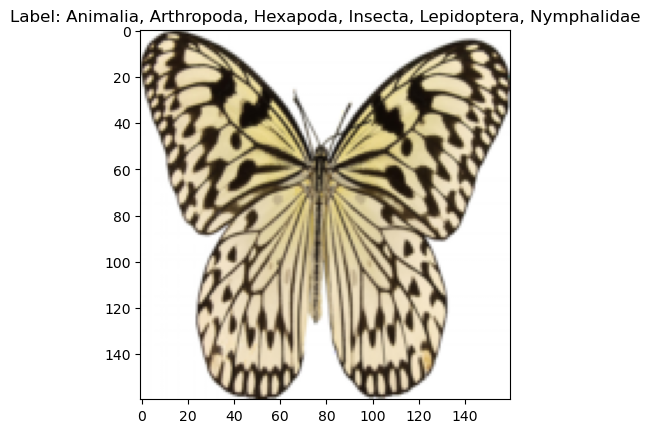

800 200


In [ ]:
# output ( (C,H,W), int)
print(test[0][0].dtype, type(test[0][1]))
print(f"Number of samples in the dataset: {len(test)}")

# get item helper
X, y = test[0]
print(X.shape, y, X.type(), type(y))

# display each digit
test.show(0)

# split data
train, dev = test.train_dev_split(0.8)
print(len(train), len(dev))

### Config
It is convenient to keep setup of specific dataset for an experiment in a config file for reproductibility

{'_target_': 'nimrod.image.datasets.ImageDataset', 'name': 'mnist', 'data_dir': '../data/image', 'split': 'test', 'transforms': {'_target_': 'torchvision.transforms.Compose', 'transforms': [{'_target_': 'torchvision.transforms.ToTensor'}, {'_target_': 'torchvision.transforms.Normalize', 'mean': [0.0], 'std': [0.2]}]}}
torch.float32 <class 'int'>
Number of samples in the dataset: 10000
torch.Size([1, 28, 28]) 7 torch.FloatTensor <class 'int'>


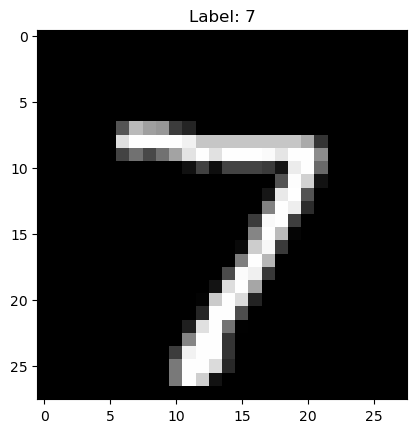

In [ ]:
# instantiate dataset from yaml config file
cfg = OmegaConf.load("../config/image/data/mnist.yaml")
print(cfg.dataset)
test = instantiate(cfg.dataset)
type(test)

# output ( (B,C, H,W), int)
print(test[0][0].dtype, type(test[0][1]))
print(f"Number of samples in the dataset: {len(test)}")

# get item helper
X, y = test[0]
print(X.shape, y, X.type(), type(y))

# display each digit
test.show(0)

# split data
train, dev = test.train_dev_split(0.8)


## Image DataModule

In [ ]:
#| export

class ImageDataModule(ImagePlotMixin, DataModule, LightningDataModule):
    def __init__(
        self,
        name: str,
        *args,
        data_dir: Optional[str] = "~/Data/", # path to source data dir
        transforms: Union[transforms.Compose, Callable, None] = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]),
        train_val_split:List[float] = [0.8, 0.2], # train val test %
        batch_size: int = 64, # size of compute batch
        num_workers: int = 0, # num_workers equal 0 means that it’s the main process that will do the data loading when needed, num_workers equal 1 is the same as any n, but you’ll only have a single worker, so it might be slow
        pin_memory: bool = False, # If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory. This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer
        persistent_workers: bool = False,
        **kwargs
        ):

        logger.info(f"Init ImageDataModule for {name}")
        super().__init__(train_val_split, batch_size, num_workers, pin_memory, persistent_workers)
        self.save_hyperparameters()
        self.train_ds, self.test_ds, self.val_ds = None, None, None
        self.int2str = None
        self._num_classes = None
        self.args = args
        self.kwargs = kwargs

    @property
    def batch_size(self)->int:
        return self.hparams.batch_size

    @property
    def num_classes(self) -> int: # num of classes in dataset
        if self._num_classes is not None:
            return self._num_classes
        raise RuntimeError("train_ds is not initialized. Call prepare_data() first.")
    
    @property
    def label_names(self) -> List[str]:  # Add this property
        if self.train_ds is not None:
            return self._label_names
        raise RuntimeError("train_ds is not initialized. Call prepare_data() first.")

    def prepare_data(self) -> None:
        """Download data if needed 
        """
        # train set
        self.train_ds = ImageDataset(
            self.hparams.name,
            *self.args,
            data_dir = self.hparams.data_dir,
            split='train',
            transforms = self.hparams.transforms,
            **self.kwargs

        )
        # get num classes before setup method converst ImageDataset to Subset
        self._num_classes = self.train_ds.num_classes
        self._label_names = self.train_ds.label_names
        # save class names before splitting test/valid and losing property
        self.int2str = self.train_ds.int2str
        # test set
        splits = self.train_ds.splits
        # test is test split from hugging face else use validation for test and split test into test/val
        if 'test' in splits:
            self.test_ds = ImageDataset(
                self.hparams.name,
                *self.args,
                data_dir = self.hparams.data_dir,
                split='test',
                transforms = self.hparams.transforms,
                **self.kwargs
            )
            if 'validation' in splits:
                self.val_ds = ImageDataset(
                    self.hparams.name,
                    *self.args,
                    data_dir = self.hparams.data_dir,
                    split='validation',
                    transforms = self.hparams.transforms,
                    **self.kwargs
                )
            else:
                self._val_ds = None # self.setup() will create validation from train set

        elif 'test' not in splits:
            if 'validation' in splits:
                # make existing val set the actual test set and split training into train/val
                self.test_ds = ImageDataset(
                    self.hparams.name,
                    *self.args,
                    data_dir = self.hparams.data_dir,
                    split='validation',
                    transforms = self.hparams.transforms,
                    **self.kwargs
                )
                self.val_ds = None
            else:
                self.setup(stage='split_train_data')
                logger.info(f"split train into train/val {self.hparams.train_val_split}")

    def setup(self, stage: Optional[str] = None) -> None:
        # called on every GPU when distrib
        # stage: {fit,validate,test,predict}\n",
        # concat train & test mnist dataset and randomly generate train, eval, test sets
        if stage == 'split_train_data':
            # TODO have separate test. here tes is a copy of val. fix later...
            logger.warning(f"split train into train/val/test {self.hparams.train_val_split} ")
            lengths = [round(split * len(self.train_ds)) for split in self.hparams.train_val_split]
            self.train_ds, self.val_ds = random_split(dataset=self.train_ds, lengths=lengths)
            self.test_ds = self.val_ds
            logger.info(f"train: {len(self.train_ds)} val: {len(self.val_ds)}, test: {len(self.test_ds)}")


        if not self.train_ds:
            raise RuntimeError("prepare_data() must be called before accessing the train dataset.")
        # if not self.test_ds:
        #     raise RuntimeError("prepare_data() must be called before accessing the test dataset.")
        if not self.val_ds:
            # dataset = ConcatDataset(datasets=[trainset, testset])
            logger.info(f"split train into train/val {self.hparams.train_val_split}")
            lengths = [round(split * len(self.train_ds)) for split in self.hparams.train_val_split]
            self.train_ds, self.val_ds = random_split(dataset=self.train_ds, lengths=lengths)
            logger.info(f"train: {len(self.train_ds)} val: {len(self.val_ds)}, test: {len(self.test_ds)}")

    
    def show(self, idx):
      self.plot(self.train_ds, idx, self.int2str)
    
    def show_grid(self, nrow, ncols):
        self.plot_grid(self.train_ds, nrow, ncols, self.int2str)
        

### Usage

[17:28:15] INFO - Init ImageDataModule for frgfm/imagenette
[17:28:23] INFO - split train into train/val [0.8, 0.2]
[17:28:23] INFO - train: 7575 val: 1894, test: 3925


 num_classes: 10, labels: ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute'], img shape: torch.Size([3, 128, 128])


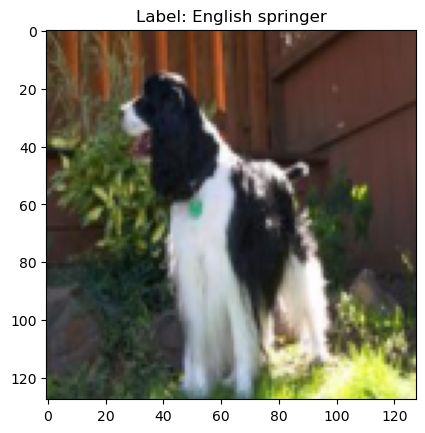

[17:28:23] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
[17:28:23] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


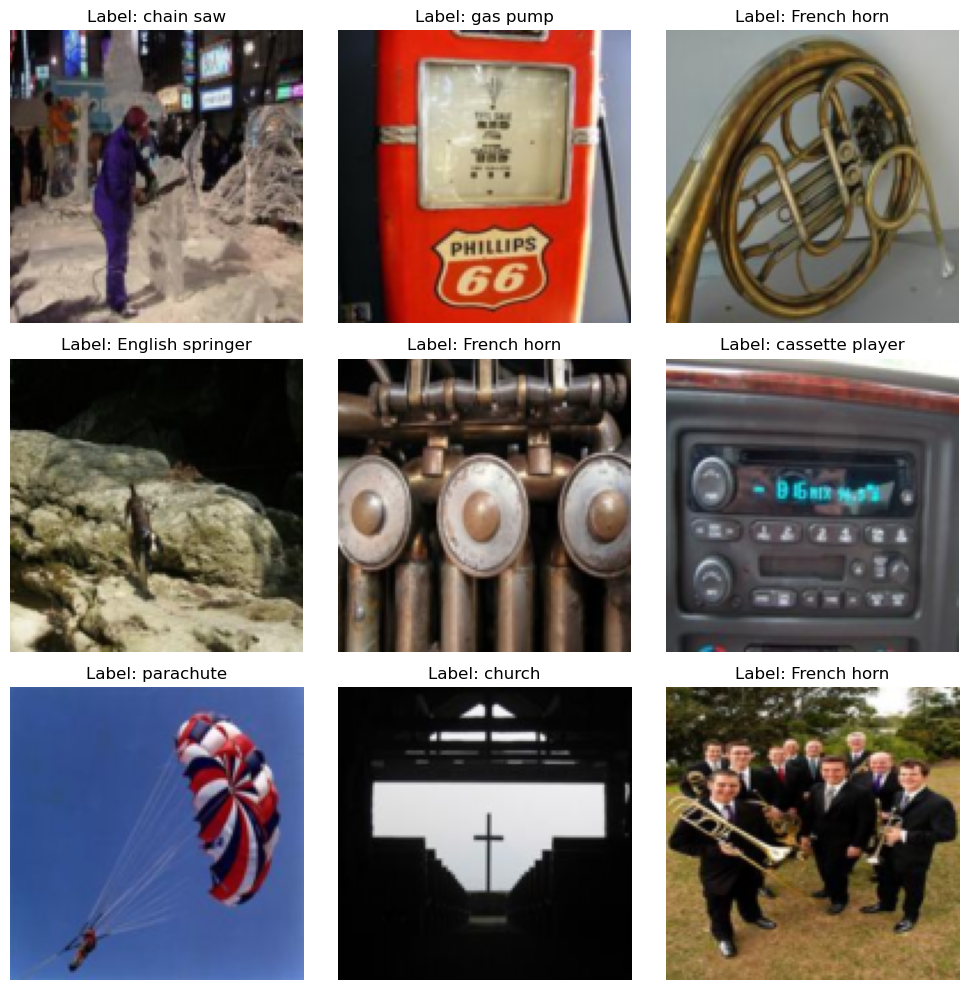

In [ ]:
#| notest

dm = ImageDataModule(
    'frgfm/imagenette','160px',
    transforms=transforms.Compose([transforms.ToTensor(),transforms.Resize((128, 128))]),
    data_dir='../data/image',
    train_val_split=[0.8, 0.2],
    batch_size = 64,
    num_workers = 0, # main process
    pin_memory= False,
    persistent_workers=False,
    exclude_grey_scale = True
)

# download or reference data from dir
dm.prepare_data()

# define train, eval, test subsets
dm.setup()
print(f" num_classes: {dm.num_classes}, labels: {dm.label_names}, img shape: {dm.train_ds[0][0].shape}")
# show data
dm.show(1)
dm.show_grid(3,3)

In [ ]:
# dm.label_names

['tench',
 'English springer',
 'cassette player',
 'chain saw',
 'church',
 'French horn',
 'garbage truck',
 'gas pump',
 'golf ball',
 'parachute']

In [ ]:
#| notest
# access data batches via dataloader
test_dl = dm.test_dataloader()
# X,Y = next(iter(test_dl))
# print("X dim(B,C,W,H): ", X.shape, "Y: dim(B)", Y.shape)


### Config

[17:28:55] INFO - Init ImageDataModule for fashion_mnist
[17:29:08] INFO - split train into train/val [0.8, 0.2]
[17:29:08] INFO - train: 48000 val: 12000, test: 10000


num_classes: 10, batch_size: 128
labels: ['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
X: torch.Size([1, 32, 32]), Y: 9


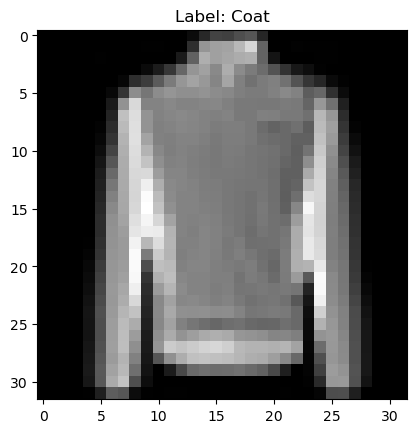

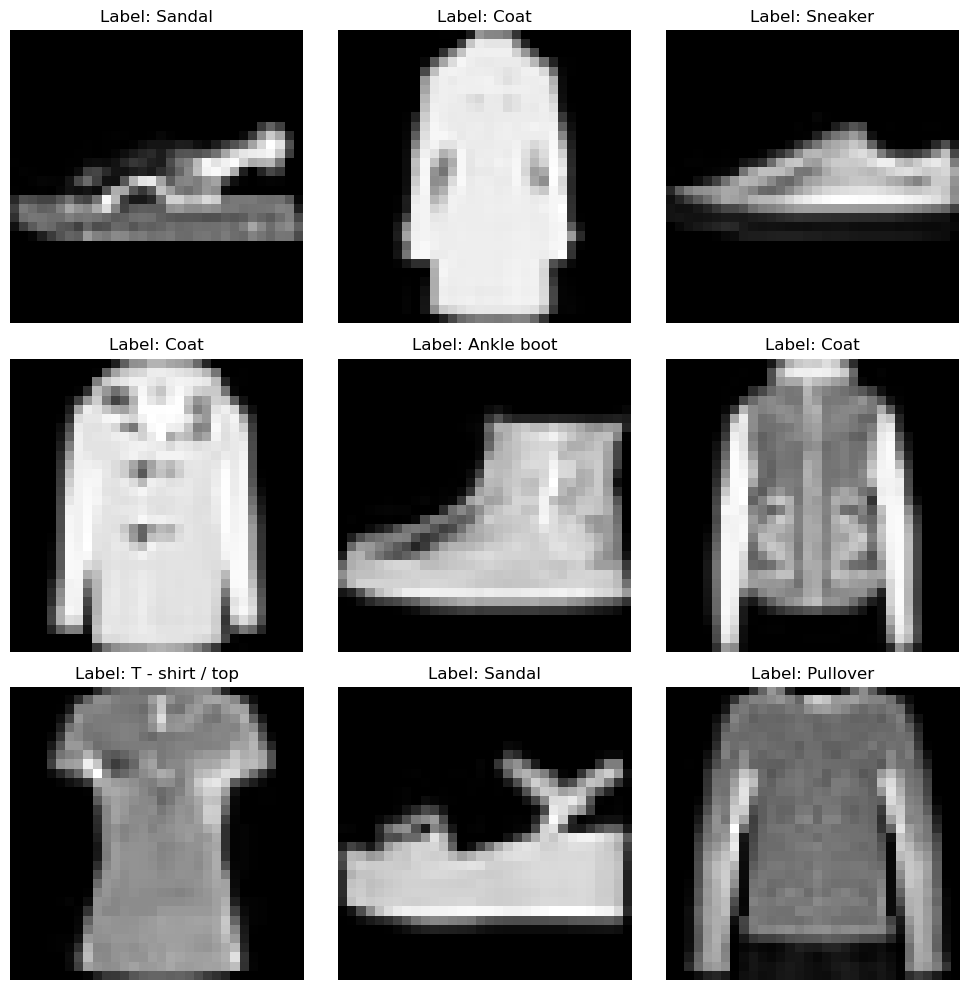

In [ ]:
#| notest

# cfg = OmegaConf.load("../config/image/data/mnist.yaml")
# print(cfg.datamodule)
# dm = instantiate(cfg.datamodule)
# dm.prepare_data()
# dm.setup()
# test_dl = dm.test_dataloader()
# len(dm.test_ds), len(dm.train_ds), len(dm.val_ds)
cfg = OmegaConf.load('../config/data/image/fashion_mnist.yaml')
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()
print(f"num_classes: {dm.num_classes}, batch_size: {dm.batch_size}")
print(f"labels: {dm.label_names}")
x, y = dm.test_ds[0]
print(f"X: {x.shape}, Y: {y}")
dm.show(1)
dm.show_grid(3,3)

[17:40:22] INFO - Init ImageDataModule for huggan/smithsonian_butterflies_subset
Repo card metadata block was not found. Setting CardData to empty.
[17:40:22] WARNING - Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
[17:40:24] WARNING - Repo card metadata block was not found. Setting CardData to empty.
[17:40:29] WARNING - split train into train/val/test [0.8, 0.2] 
[17:40:29] INFO - train: 800 val: 200, test: 200
[17:40:29] INFO - split train into train/val [0.8, 0.2]
[17:40:29] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8029231..1.0000005].


num_classes: 45, batch_size: 128
labels: ['Animalia, Arthropoda, Insecta, Lepidoptera, Pyralidae, Epipaschiinae', 'Animalia, Arthropoda, Insecta, Lepidoptera, Geometridae, Larentiinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae, Nymphalinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae, Satyrinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Saturniidae, Saturniinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae, Limenitidinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Papilionidae, Papilioninae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Pieridae, Dismorphiinae', 'Animalia, Arthropoda, Insecta, Lepidoptera, Arctiidae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Lycaenidae', 'Animalia, Arthropoda, Insecta, Lepidoptera, Papilionidae, Parnassiinae', 'Animalia, Arthropoda, Insecta, Lepidoptera, Pyralidae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Pieridae',

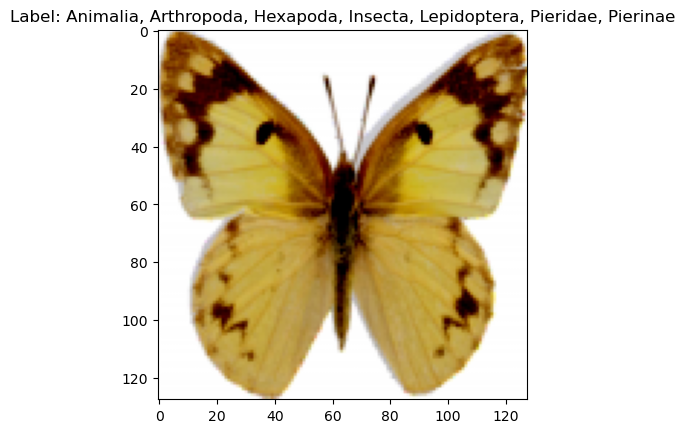

In [ ]:
#| notest
cfg = OmegaConf.load('../config/data/image/smithsonian_butterflies.yaml')
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()
print(f"num_classes: {dm.num_classes}, batch_size: {dm.batch_size}")
print(f"labels: {dm.label_names}")
x, y = dm.test_ds[0]
print(f"X: {x.shape}, Y: {y}")
x,y = next(iter(dm.train_dataloader()))
print(f"X: {x.shape}, Y: {y.shape}")
dm.show(1)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()